In [95]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

Load the data

In [96]:
input_file = 'data/processed_data.csv'
df = pd.read_csv('data/processed_data.csv', parse_dates=['DateTime'], index_col='DateTime')
df = df.resample('60T').mean()
df = df[(df['Temperature'] >= df['Temperature'].quantile(0.1)) & (df['Temperature'] <= df['Temperature'].quantile(0.9))]
# df["DateTime"] = pd.to_datetime(df.index)
df = df.reset_index()

Rename the columns for better readability

In [97]:
# df.columns = ['DateTime', 'Year', 'Month', 'Date', 'Time', 'Minute', 'Temperature', 'Previous Day Average', 'Two Days Before Average',
              #'Three Days Before average', 'Last 7 Days Average', 'Previous Day Wind Speed', 'Previous Day Rainfall']

Convert the 'Date' and 'Time' columns to integers

In [98]:
df['Date'] = df['Date'].astype(int)
df['Time'] = df['Time'].astype(int)

Fill leading zeros for the 'Time' column

In [99]:
df['Time'] = df['Time'].apply(lambda x: str(x).zfill(4))

Combine the 'Date' and 'Time' columns into a single 'DateTime' column

In [100]:
# df['DateTime'] = pd.to_datetime(df["DateTime"], format="%Y-%m-%d %H:%M:%S")

Remove rows with a specific value (e.g., 32767) in 'Temperature' column

In [101]:
df = df[df['Temperature'] != 32767]

Calculate the mean and standard deviation of Y

In [102]:
threshold = 5
mean_Y = np.mean(df['Temperature'])
std_Y = np.std(df['Temperature'])

Define the range of acceptable Y values

In [103]:
lower_bound = mean_Y - threshold * std_Y
upper_bound = mean_Y + threshold * std_Y

Filter out rows with Y values outside the acceptable range

In [104]:
df = df[(df['Temperature'] >= lower_bound) & (df['Temperature'] <= upper_bound)]

Prepare the data for LSTM

In [105]:
time_steps = 60  # Number of time steps for the LSTM model
scaler = MinMaxScaler(feature_range=(0, 1))  # Scale the data to [0, 1]

Scale the temperature values

In [106]:
scaled_temperature = scaler.fit_transform(df['Temperature'].values.reshape(-1, 1))

Create sequences of input data and corresponding target values

In [107]:
data = []
target = []
for i in range(24, len(scaled_temperature) - time_steps):
    data.append(scaled_temperature[i-24:i+time_steps-24])
    target.append(scaled_temperature[i+time_steps])


In [108]:
data = np.array(data)
target = np.array(target)

In [109]:
df["DateTime"]

0       2008-01-08 00:00:00
1       2008-01-08 03:00:00
2       2008-01-08 04:00:00
3       2008-01-08 05:00:00
4       2008-01-08 06:00:00
                ...        
99922   2023-06-29 09:00:00
99923   2023-06-29 20:00:00
99924   2023-06-29 21:00:00
99925   2023-06-29 22:00:00
99926   2023-06-29 23:00:00
Name: DateTime, Length: 99927, dtype: datetime64[ns]

Define exclude date (year, month, and day)

In [110]:
exclude_year = 2023
exclude_month = 6
exclude_day = 1

Split the dataset into training and validation sets

In [111]:
exclude_date = pd.to_datetime(f"{exclude_year}-{exclude_month}-{exclude_day}")
exclude_index = df[df['DateTime'] >= exclude_date].index[0]
print(exclude_index)
train_data, train_target = data[:exclude_index], target[:exclude_index]
val_data, val_target = data[exclude_index:], target[exclude_index:]

99388


Build the LSTM model architecture

In [112]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(time_steps, 1)),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

2023-06-29 21:11:45.375120: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-29 21:11:45.377025: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-29 21:11:45.378075: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Compile the model

In [113]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mean_absolute_error', optimizer=optimizer)

Define early stopping and learning rate scheduler

In [114]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

Train the LSTM model

In [115]:
batch_size = 64
epochs = 100
history = model.fit(train_data, train_target, batch_size=batch_size, epochs=epochs, validation_data=(val_data, val_target),
                    callbacks=[early_stopping, lr_scheduler])

Epoch 1/100


2023-06-29 21:11:45.719497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-29 21:11:45.720744: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-29 21:11:45.721675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-06-29 21:11:46.450140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-29 21:11:46.451645: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-29 21:11:46.452561: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Make predictions using the trained LSTM model

In [ ]:
predictions = model.predict(val_data)

2023-06-29 19:06:53.292566: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-29 19:06:53.294024: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-29 19:06:53.294908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

15/15 [==============================] - 1s 11ms/step


Rescale the predictions back to the original range

In [ ]:
scaled_predictions = predictions.reshape(-1, 1)
predicted_temperature = scaler.inverse_transform(scaled_predictions)

Calculate MSE and MAE

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(scaler.inverse_transform(val_target), predicted_temperature)
mae = mean_absolute_error(scaler.inverse_transform(val_target), predicted_temperature)

In [ ]:
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)

Mean Squared Error (MSE): 0.09682441181829658
Mean Absolute Error (MAE): 0.2210032707670627


Visualize the actual vs. predicted temperatures for the validation set

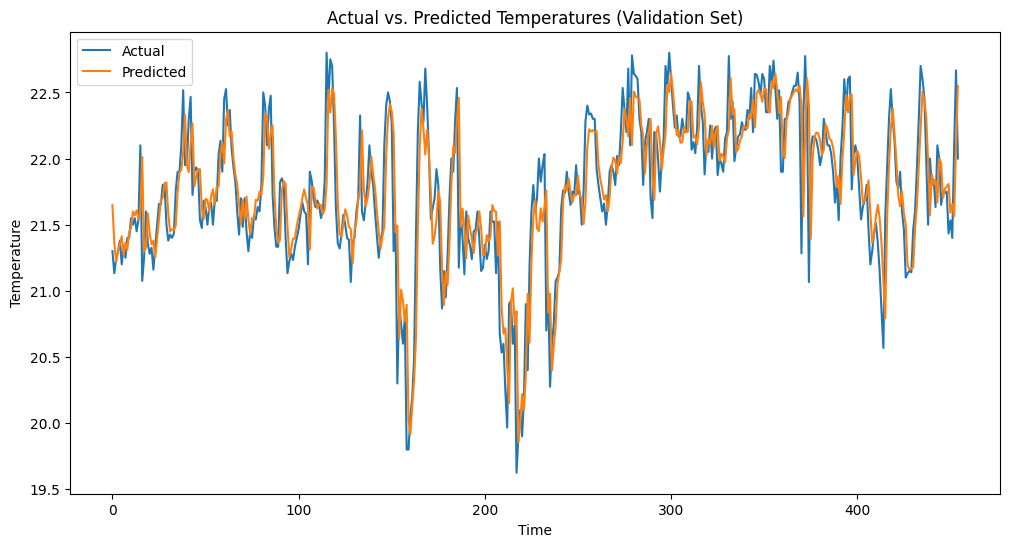

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(val_target)), scaler.inverse_transform(val_target), label='Actual')
plt.plot(range(len(val_target)), predicted_temperature, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Actual vs. Predicted Temperatures (Validation Set)')
plt.legend()
plt.show()

Visualize the actual vs. predicted temperatures for the training set

3106/3106 [==============================] - 38s 12ms/step


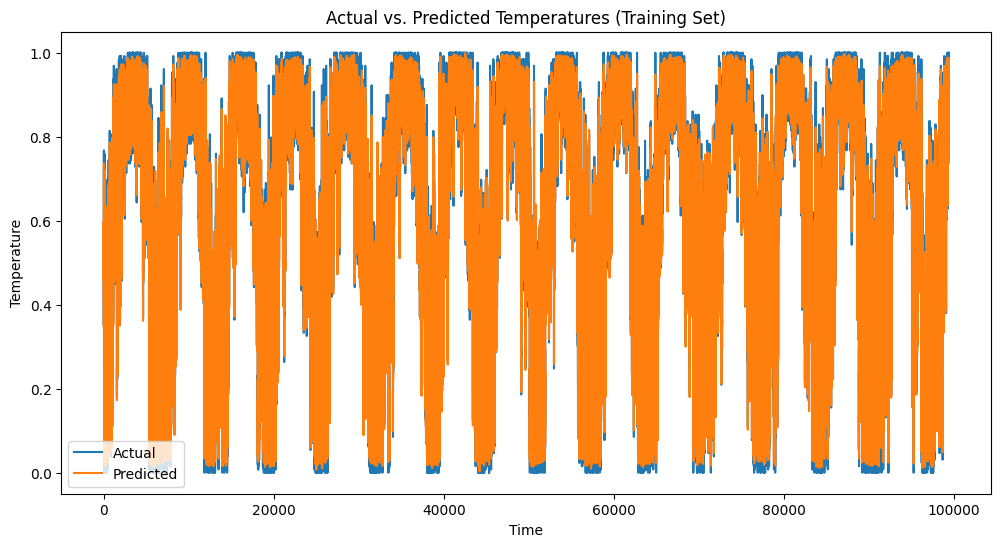

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(train_target)), train_target, label='Actual')
plt.plot(range(len(train_target)), model.predict(train_data), label='Predicted')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Actual vs. Predicted Temperatures (Training Set)')
plt.legend()
plt.show()

Save the trained model

In [ ]:
model.save("lstm.keras")